In [1]:
########## Telechargement des modules ########## 
! pip3 install Pillow
! pip3 install graphviz pydotplus
! pip3 install pydot
! pip3 install pydotplus
! pip3 install graphviz
! python3 -m pip install kaggle

########## Importation des librairies ##########

from PIL import Image
from PIL.ExifTags import TAGS
import json
import os
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial import KDTree
from webcolors import (CSS3_HEX_TO_NAMES, hex_to_rgb,)
import random
from IPython.display import clear_output
import kaggle
import zipfile
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
########## Variables ##########
dictionnaire_preferences = {}

########## Suppression des warnings ##########
def warn(*args, **kwargs):
    pass

warnings.warn = warn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
##########  Telechargement des images ########## 
! kaggle datasets download -d vishalsubbiah/pokemon-images-and-types
os.getcwd()
with zipfile.ZipFile('pokemon-images-and-types.zip', 'r') as zip_ref:
    zip_ref.extractall('ImagesPokemonUNZIPPED')

pokemon-images-and-types.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
########## Suppression des images Mods P ##########
def convert_P_to_RGBA():
    dossier = "ImagesPokemonUNZIPPED/images/images"
    for filename in os.listdir(dossier):
        imagename = os.path.join(dossier, filename)

        if os.path.isfile(imagename):
            image = Image.open(imagename)
            if image.mode == 'P':
                image2 = image.convert('RGBA')
                image2.save(image.filename)
    return "Ok"

In [5]:
########### function qui covertie les nombre RGB en Nom de couleur ##########
def rgb_to_name(rgb):
    # a disctionnary of all the hex and their respective names in css3
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb)
    return f'{names[index]}'

In [6]:
########## Fonction qui permet de trouver les couleurs prédominantes ##########

def find_predominant_color(imagepath):

    nombre_couleurs = 5 #Un de plus que ce qu'on veux

    imgfile = Image.open(imagepath)
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    clusters = MiniBatchKMeans(n_clusters=nombre_couleurs)
    clusters.fit(numarray)
    npbins = numpy.arange(0, nombre_couleurs+1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    [list1,list2] = histogram
    list1,list2 = zip(*sorted(zip(list1,list2),reverse=True))
    histogram_sort = [list1,list2]

    labels = numpy.unique(clusters.labels_)
    list_colors = []
    colornames = []
    for i in range(nombre_couleurs-1):
        list_colors.append(
            "#%02x%02x%02x"
            % (
                math.ceil(clusters.cluster_centers_[list2[i+1]][0]),
                math.ceil(clusters.cluster_centers_[list2[i+1]][1]),
                math.ceil(clusters.cluster_centers_[list2[i+1]][2]),
            )
        )
        rgb = [math.ceil(clusters.cluster_centers_[list2[i+1]][0]),
                math.ceil(clusters.cluster_centers_[list2[i+1]][1]),
                math.ceil(clusters.cluster_centers_[list2[i+1]][2]),]
        colornames.append(rgb_to_name(rgb))

    return colornames

In [7]:
########## Création du fichier JSON ##########

def write_json(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

In [8]:
########## recuperation des informations du fichier JSON ##########
def get_infos_JSON():
    toutes_les_infos = []
    df = pd.read_csv('All_Pokemon.csv', sep=',')
    dossier = "ImagesPokemonUNZIPPED/images/images/"
    for filename in os.listdir(dossier):
        imagename = os.path.join(dossier, filename)
        if os.path.isfile(imagename):
            image = Image.open(imagename)
            couleur = find_predominant_color(imagename)

            for i in range(len(df)):
                if df["Name"][i].lower() == image.filename.split(".")[0].split("/")[3]:
                    #type2 = df["Type 2"][i]
                    #if type2 == "NaN":
                    #    type2 = "None"
                    info_dict = {
                    "Filename": image.filename,
                    "Name" : image.filename.split(".")[0].split("/")[3].capitalize(),
                    "Image Size": image.size,
                    "Image Height": image.height,
                    "Image Width": image.width,
                    "Image Format": image.format,
                    "Image Mode": image.mode,
                    "Image is Animated": getattr(image, "is_animated", False),
                    "Frames in Image": getattr(image, "n_frames", 1),
                    "Predominant color": [
                        couleur[0],
                        couleur[1],
                        couleur[2],
                        couleur[3]
                    ],
                    "Type 1": df["Type 1"][i],
                    #"Type 2": type2,
                    "Generation": df["Generation"][i],
                    "Legendary": df["Legendary"][i],
                    "Mega Evolution": df["Mega Evolution"][i],
                    "Height": df["Height"][i],
                    "Weight": df["Weight"][i],
                    }
                    toutes_les_infos.append(info_dict)
                    #print("Pokemon trouvé : " + image.filename.split(".")[0].split("/")[3].capitalize())
                    break
    return toutes_les_infos

In [9]:
########## Récupération des tags relatifs aux images ##########

def get_all_tags():
    tags = []
    with open('pokemonjson.json', 'r') as f:
        jason = json.load(f)
    for pokemon in jason:
        tags.append([pokemon["Filename"].split(".")[0].split("/")[3].capitalize(),pokemon["Predominant color"][0],pokemon["Predominant color"][1],pokemon["Predominant color"][2],pokemon["Predominant color"][3],pokemon["Type 1"],pokemon["Generation"],pokemon["Legendary"],pokemon["Mega Evolution"],pokemon["Height"],pokemon["Weight"]])
    return tags

In [10]:
########## Récupération d'une image aléatoire et de ses tags ##########

def random_image_and_tags():
    dossier = "ImagesPokemonUNZIPPED/images/images/"
    imagename = random.choice(os.listdir(dossier))
    image = Image.open(os.path.join(dossier, imagename))
    
    tags = []
    pokemons = get_all_tags()
    for pokemon in pokemons:
        if image.filename.split(".")[0].split("/")[3].capitalize() in pokemon[0]:
            tags.append(pokemon[1])
            tags.append(pokemon[5])
            tags.append(pokemon[6])
            tags.append(pokemon[7])
            break
    if tags == []:
        random_image_and_tags()
    else:
        return tags, image, imagename

In [11]:
########## Récupération d'une image non aléatoire et de ses tags ##########

def tags_of_image(imagename):
    image = Image.open(os.path.join("ImagesPokemonUNZIPPED/images/images/", imagename))

    tags = []
    pokemons = get_all_tags()
    for pokemon in pokemons:
        if image.filename.split(".")[0].split("/")[3].capitalize() in pokemon[0]:
            tags.append(pokemon[1])
            tags.append(pokemon[5])
            tags.append(pokemon[6])
            tags.append(pokemon[7])
            break
    return tags, image, imagename

In [12]:
########## Génération des préférences de l'utilisateur en lui montrant des images ##########
def generate_preferences():
    liste_tags = []
    liste_fav_or_not = []
    liste_chemins_fav = []
    liste_des_trucs_vus = []
    nombre_favoris = 15
    i = 0
    print("vous allez devoir choisir {} photos favorites".format(nombre_favoris)) 
    while i != nombre_favoris :
        try:
            (tags, image, imagename) = random_image_and_tags()
            if tags not in liste_des_trucs_vus:
                liste_des_trucs_vus.append(tags)
                clear_output(wait=True)
                plot.imshow(image)
                plot.show()
                print("Do you like this image ? (y/n)")
                reponse = input()
                if reponse == "y":
                    liste_fav_or_not.append("Favori")
                    liste_chemins_fav.append(imagename)
                    i+=1
                    liste_tags.append(tags)
        except:
            pass
    return liste_tags, liste_fav_or_not, liste_chemins_fav

In [13]:
########## Génération d'une image que pourrait aimer l'utilisateur#########
def generate_favorite_image(username):

    data = dictionnaire_preferences[username][0].copy()
    result = dictionnaire_preferences[username][1].copy()

    for imagename in os.listdir("ImagesPokemonUNZIPPED/images/images/"):
        path = os.path.join("ImagesPokemonUNZIPPED/images/images/", imagename)
        if os.path.isfile(path):
            tags, imagezzz, imagenamezzz = tags_of_image(imagename)
            if tags not in data and tags != []:
                data.append(tags)
                result.append("Non favori")
   
    
    # creating dataframes
    dataframe = pd.DataFrame(data, columns=["color1", "type", "generation", "legendary"])
    resultframe = pd.DataFrame(result, columns=["favorite"])

    # generating numerical labels
    le1 = LabelEncoder()
    dataframe["color1"] = le1.fit_transform(dataframe["color1"])

    le5 = LabelEncoder()
    dataframe["type"] = le5.fit_transform(dataframe["type"])

    le6 = LabelEncoder()
    dataframe["generation"] = le6.fit_transform(dataframe["generation"])

    le7 = LabelEncoder()
    dataframe["legendary"] = le7.fit_transform(dataframe["legendary"])

    le11 = LabelEncoder()
    resultframe["favorite"] = le11.fit_transform(resultframe["favorite"])

    # Use of decision tree classifiers
    dtc = tree.DecisionTreeClassifier()
    dtc = dtc.fit(dataframe.values, resultframe)

   
    ohcestbonla = 0
    avis = "Non favori"
    while avis == "Non favori" and ohcestbonla < 2000:
        try:
            (tags, image, imagename) = random_image_and_tags()

            # prediction
            prediction = dtc.predict(
                [
                    [
                        le1.transform([tags[0]])[0],
                        le5.transform([tags[1]])[0],
                        le6.transform([tags[2]])[0],
                        le7.transform([tags[3]])[0],
                    ]
                ]
            )
            avis = le11.inverse_transform(prediction)
            if imagename in dictionnaire_preferences[username][2]:
                avis = "Non favori"
            ohcestbonla += 1
        except:
            pass
    if ohcestbonla >= 2000:
        print("Pas d'image favorite trouvée :o")
    else:
        plot.imshow(image)
        plot.show()
        print("Do you like this image ? (y/n)")
        reponse = input()
        if reponse == "y":
            dictionnaire_preferences[username][0].append(tags)
            dictionnaire_preferences[username][1].append("Favori")
            dictionnaire_preferences[username][2].append(imagename)  

In [14]:
########## permet de montrer les images preferes d'un utilisateur ainsi que leurs informations##########
def get_user_info(username):
    for i in range(len(dictionnaire_preferences[username][0])):
        path = os.path.join("ImagesPokemonUNZIPPED/images/images/", dictionnaire_preferences[username][2][i])
        image = Image.open(path)
        plot.imshow(image)
        plot.show()
        print(dictionnaire_preferences[username][0][i], dictionnaire_preferences[username][1][i])
        if input("voulez vous voir l'image suivante (y/n)") != "y":
            break

In [15]:
########## Création des comptes utilisateurs et leur propose des images et/ou affiche leurs information ##########

def generate_user_preferences():
    username = input("Rentrez votre nom d'utilisateur : ")
    if username in dictionnaire_preferences:
        print("Vous avez déjà un compte")
        if input("Voulez vous voir vos informations? (y/n)") == "y":
            get_user_info(username)
        if input("Voulez vous voir une image favorite? (y/n)") == "y":
            generate_favorite_image(username)
    else:
        liste_tags, liste_fav_or_not, liste_chemins_fav = generate_preferences()
        dictionnaire_preferences[username] = [liste_tags, liste_fav_or_not, liste_chemins_fav]
        print("Votre compte a bien été créé")

In [16]:
########## Fonction d'initialisation ###########
def initialiation():
    convert_P_to_RGBA()
    write_json("pokemonjson.json", get_infos_JSON())

Vous avez déjà un compte


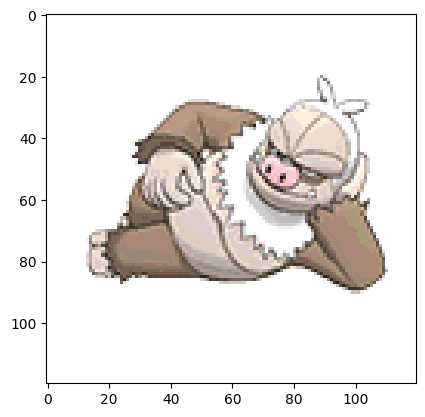

['antiquewhite', 'Normal', 3.0, 0.0] Favori


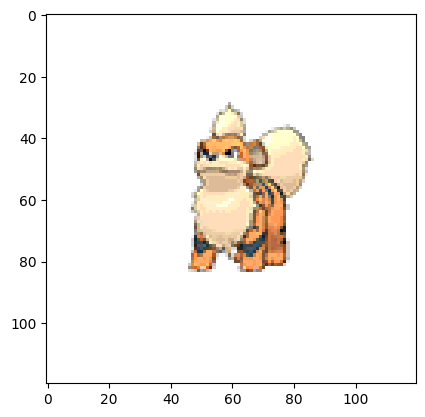

['darksalmon', 'Fire', 1.0, 0.0] Favori


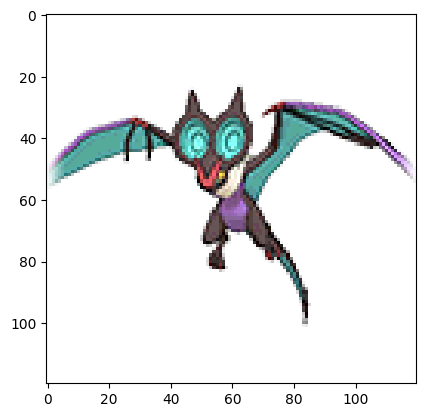

['cadetblue', 'Flying', 6.0, 0.0] Favori


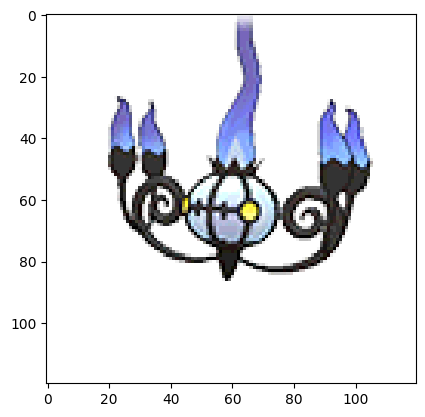

['darkslategray', 'Ghost', 5.0, 0.0] Favori


In [17]:
########## Génération d'une image favorite (enfin on essaie) ##########

def main():
    initialiation()
    boule = True
    while(boule):
        generate_user_preferences()
        clear_output(wait=True)
        if input("Voulez vous continuer ? (y/n)") == "y":
            boule = True
        else:
            boule = False

########lancement ########
main()